# TP2 Zero-Shot

Imports

In [1]:
import torch
import os
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from PIL import Image
from torchvision import transforms
import requests
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
import cv2

C:\Users\cocor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
"a"*4

'aaaa'

In [2]:
model_name = "CIDAS/clipseg-rd64-refined"
processor = CLIPSegProcessor.from_pretrained(model_name)
model = CLIPSegForImageSegmentation.from_pretrained(model_name)

In [36]:

# Définis le dossier contenant les images
image_dir = "baseline/baseline/highway/input"  
ground_truth_dir = "baseline/baseline/highway/groundtruth"  
nombre_fichiers = len([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
nombre_fichiers_groundtruth = len([f for f in os.listdir(ground_truth_dir) if os.path.isfile(os.path.join(ground_truth_dir, f))])
assert nombre_fichiers == nombre_fichiers_groundtruth
# Liste d'exemples avec le chemin des images
examples = []
ground_truth_list = []  
for i in range( nombre_fichiers) : 
    examples.append({"path" : "in"+str(0)*(5-int(np.log10(i+1)))+str(i+1)+".jpg","prompt" : "car"})
    
    ground_truth_list.append({"path":"gt"+str(0)*(5-int(np.log10(i+1)))+str(i+1)+".png","prompt" : "car"})

# Boucle sur chaque exemple
c = 0
iou_list = []
for index in range(470,len(examples)):
    image_path = os.path.join(image_dir, examples[index]["path"])  # Construire le chemin absolu
    ground_truth_path = os.path.join(ground_truth_dir, ground_truth_list[index]["path"])  # Construire le chemin absolu
    # Vérifier si l'image existe
    if not os.path.exists(image_path):
        print(f"Image non trouvée : {image_path}")
        continue

    if not os.path.exists(ground_truth_path):
        print(f"groundtruth non trouvée : {ground_truth_path}")
        continue
    # Charger l'image et la convertir en RGB
    image = Image.open(image_path).convert("RGB")
    ground_truth = Image.open(ground_truth_path).convert("RGB")
    
    ground_truth = np.array(ground_truth)
    ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)
    
    _, ground_truth_binary = cv2.threshold(ground_truth_gray, 127, 180, cv2.THRESH_BINARY)

    
    
    
    # Prétraitement de l'image et du texte
    inputs = processor(text=examples[i]["prompt"], images=image, return_tensors="pt")

    # Inférence (mode évaluation)
    with torch.no_grad():
        outputs = model(**inputs)

    # Extraire le masque de segmentation
    pred_mask = outputs.logits.sigmoid().detach().cpu().numpy()[0]
    mask_binary = pred_mask > 0.45  # Seuil binaire
    # Redimensionner ground_truth pour qu'il ait la même taille que mask_binary
    ground_truth_resized = cv2.resize(ground_truth_binary, (mask_binary.shape[1], mask_binary.shape[0]))
    
    assert mask_binary.shape == ground_truth_resized.shape
    ground_truth_resized = (ground_truth_resized>127).astype(np.uint8)
    mask_binary = mask_binary.astype(np.uint8)

    # Calcul de l'IoU
    intersection = np.logical_and(mask_binary, ground_truth_resized).sum()
    union = np.logical_or(mask_binary, ground_truth_resized).sum()
    iou = intersection / union if union > 0 else 0
    iou_list.append(iou)
    # Afficher l'image originale et le masque
    c+=1
    if c%100==0 :
        
        plt.figure(figsize=(12, 6))
        plt.suptitle(f"Requête : {examples[i]['prompt']}")

        plt.subplot(1, 2, 1)
        plt.imshow(ground_truth_resized,cmap="gray")
        plt.title("ground truth ")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(mask_binary, cmap="gray")
        plt.title("Masque de segmentation")
        plt.axis("off")

        print(np.mean(iou_list))


        plt.show()

KeyboardInterrupt: 

In [50]:
def get_results(examples,ground_truth_list,plot_images = True) :
    
    iou_list = []
    for index in range(len(examples)):
        image_path = os.path.join(image_dir, examples[index]["path"])  # Construire le chemin absolu
        ground_truth_path = os.path.join(ground_truth_dir, ground_truth_list[index]["path"])  # Construire le chemin absolu
        # Vérifier si l'image existe
        if not os.path.exists(image_path):
            print(f"Image non trouvée : {image_path}")
            continue

        if not os.path.exists(ground_truth_path):
            print(f"groundtruth non trouvée : {ground_truth_path}")
            continue
        # Charger l'image et la convertir en RGB
        image = Image.open(image_path).convert("RGB")
        ground_truth = Image.open(ground_truth_path).convert("RGB")

        ground_truth = np.array(ground_truth)
        ground_truth_gray = cv2.cvtColor(ground_truth, cv2.COLOR_RGB2GRAY)

        _, ground_truth_binary = cv2.threshold(ground_truth_gray, 127, 180, cv2.THRESH_BINARY)



        # Prétraitement de l'image et du texte
       
        inputs = processor(text=examples[index]["prompt"], images=image, return_tensors="pt")

        # Inférence (mode évaluation)
        with torch.no_grad():
            outputs = model(**inputs)

        # Extraire le masque de segmentation
        pred_mask = outputs.logits.sigmoid().detach().cpu().numpy()[0]
        mask_binary = pred_mask > 0.45  # Seuil binaire
        # Redimensionner ground_truth pour qu'il ait la même taille que mask_binary
        ground_truth_resized = cv2.resize(ground_truth_binary, (mask_binary.shape[1], mask_binary.shape[0]))

        assert mask_binary.shape == ground_truth_resized.shape
        ground_truth_resized = (ground_truth_resized>127).astype(np.uint8)
        mask_binary = mask_binary.astype(np.uint8)

        # Calcul de l'IoU
        intersection = np.logical_and(mask_binary, ground_truth_resized).sum()
        union = np.logical_or(mask_binary, ground_truth_resized).sum()
        iou = intersection / union if union > 0 else 0
        if iou>0 :
            iou_list.append(iou)
            # Afficher l'image
            if  iou>0.8 or iou<0.1 and plot_images :
                
                if iou<0.1 :
                    print("Mauvaise segmentation")
                else : 
                    print("Bonne segmentation")
                plt.figure(figsize=(12, 6))
                plt.suptitle(f"Requête : {examples[index]['prompt']}")

                plt.subplot(1, 3, 1)
                plt.imshow(ground_truth_resized,cmap="gray")
                plt.title("ground truth ")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask_binary, cmap="gray")
                plt.title("Masque de segmentation")
                plt.axis("off")
                plt.subplot(1, 3, 3)
                plt.imshow(image)
                plt.title("image")
                plt.axis("off")
                plt.show()
    return iou_list

Mauvaise segmentation


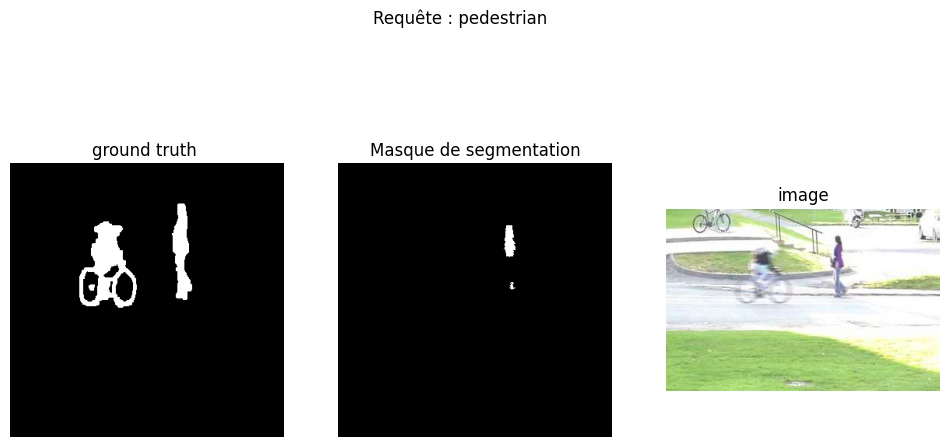

Bonne segmentation


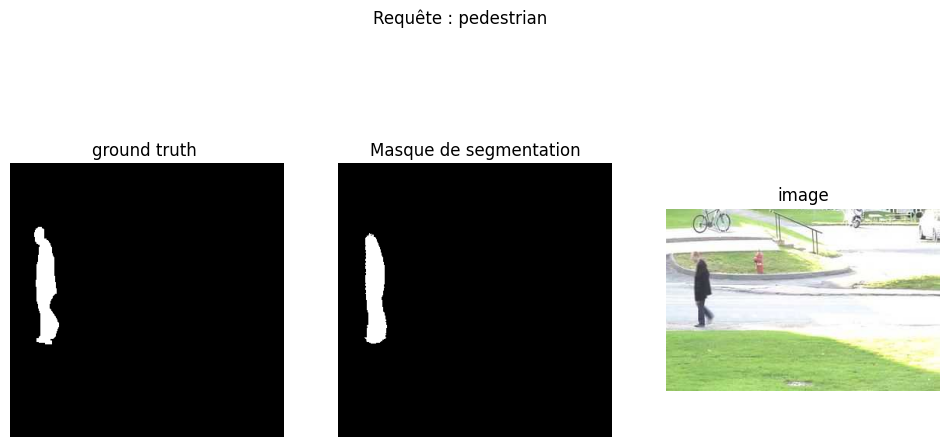

Bonne segmentation


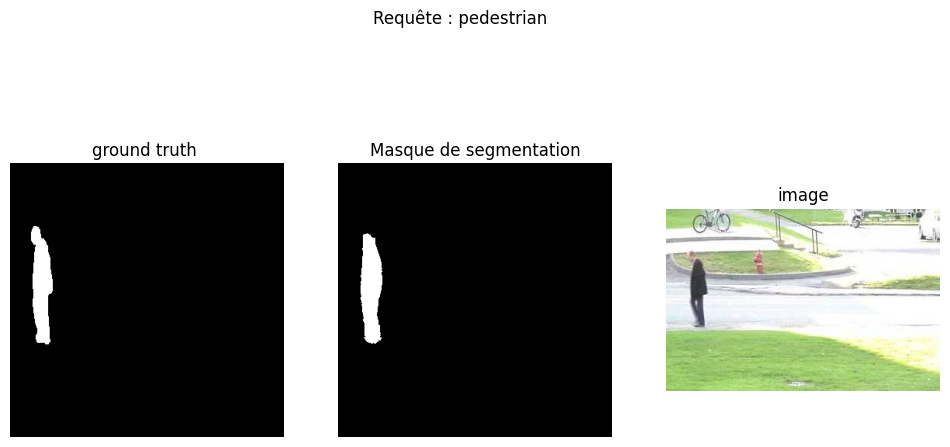

0.5851406423376461


In [40]:

# Définis le dossier contenant les images
image_dir = "baseline/baseline/pedestrians/input"  
ground_truth_dir = "baseline/baseline/pedestrians/groundtruth"  
nombre_fichiers = len([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
nombre_fichiers_groundtruth = len([f for f in os.listdir(ground_truth_dir) if os.path.isfile(os.path.join(ground_truth_dir, f))])
assert nombre_fichiers == nombre_fichiers_groundtruth
# Liste d'exemples avec le chemin des images
examples = []
ground_truth_list = []  
for i in range( 300 , nombre_fichiers) : 
    examples.append({"path" : "in"+str(0)*(5-int(np.log10(i+1)))+str(i+1)+".jpg","prompt" : "pedestrian"})
    
    ground_truth_list.append({"path":"gt"+str(0)*(5-int(np.log10(i+1)))+str(i+1)+".png","prompt" : "pedestrian"})

# Boucle sur chaque exemple
iou_list = get_results(examples,ground_truth_list)
print(np.mean(iou_list))
   

    
    
    




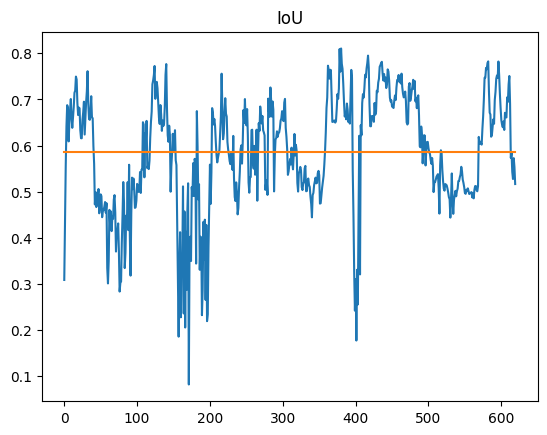

In [42]:
plt.plot(iou_list)
plt.plot(np.ones(len(iou_list))*np.mean(iou_list))
plt.title("IoU")
plt.show()

# Animaux camouflés

Bonne segmentation


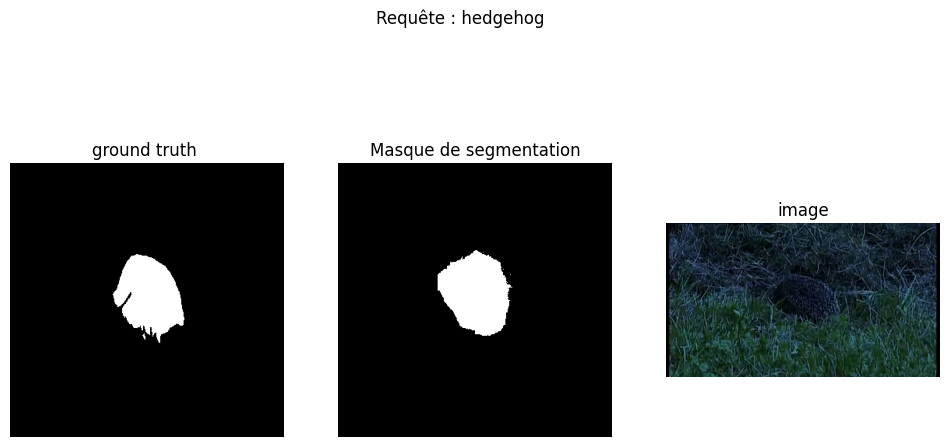

Bonne segmentation


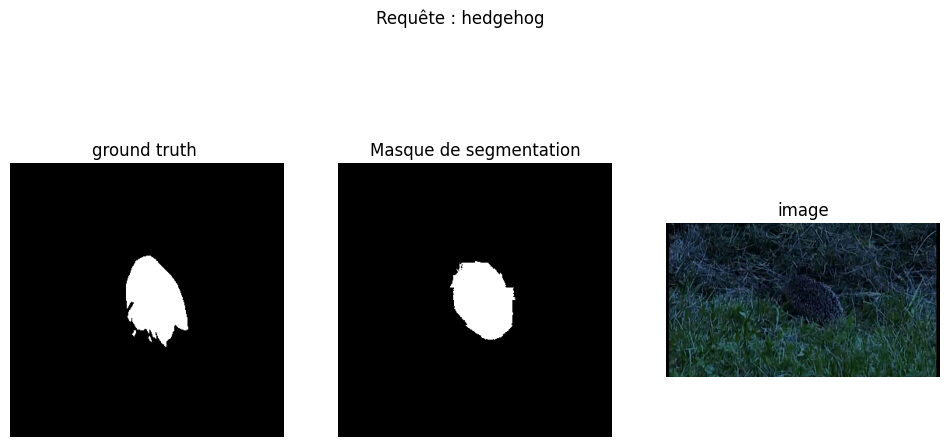

Bonne segmentation


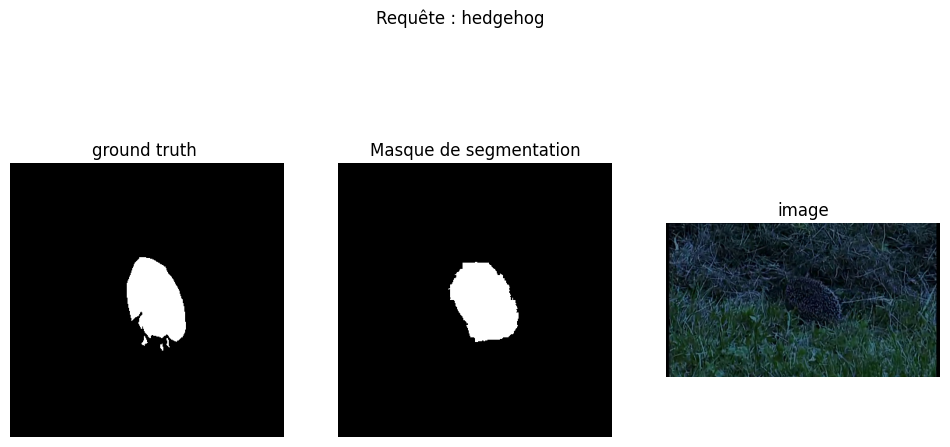

Bonne segmentation


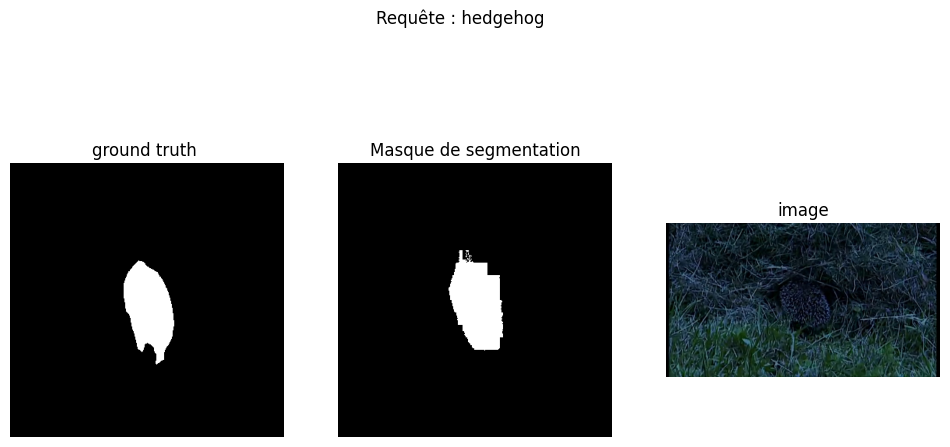

Mauvaise segmentation


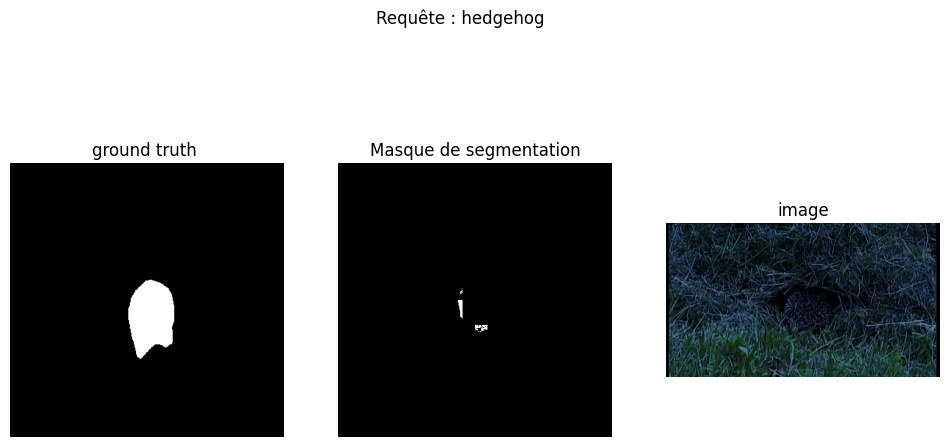

0.6944150455950865


In [45]:

# Définis le dossier contenant les images
image_dir = "hedgehog_0\Imgs"  
ground_truth_dir = "hedgehog_0\GT"  
nombre_fichiers = len([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
nombre_fichiers_groundtruth = len([f for f in os.listdir(ground_truth_dir) if os.path.isfile(os.path.join(ground_truth_dir, f))])
assert nombre_fichiers == nombre_fichiers_groundtruth
# Liste d'exemples avec le chemin des images
examples = []
ground_truth_list = []  
for i in range( nombre_fichiers) : 
    examples.append({"path" : str(0)*(4-int(np.log10(i*5 +1)))+str(i*5)+".jpg","prompt" : "hedgehog"})
    
    ground_truth_list.append({"path":str(0)*(4-int(np.log10(i*5 + 1)))+str(i*5)+".png","prompt" : " hedgehog"})

# Boucle sur chaque exemple

iou_list = get_results(examples,ground_truth_list)
print(np.mean(iou_list))




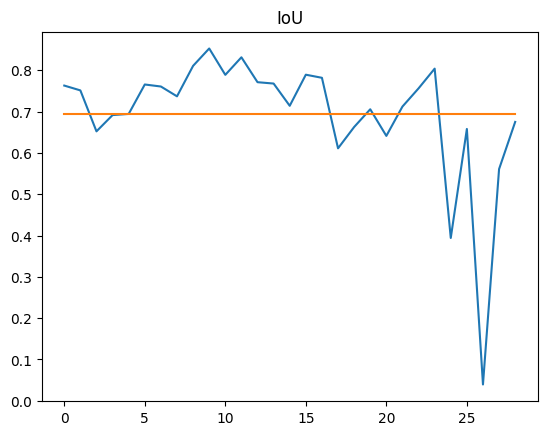

In [46]:
plt.plot(iou_list)
plt.plot(np.ones(len(iou_list))*np.mean(iou_list))
plt.title("IoU")
plt.show()

In [51]:
# Définis le dossier contenant les images
image_dir = "stick_insect_0\Imgs"  
ground_truth_dir = "stick_insect_0\GT"  
nombre_fichiers = len([f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))])
nombre_fichiers_groundtruth = len([f for f in os.listdir(ground_truth_dir) if os.path.isfile(os.path.join(ground_truth_dir, f))])
assert nombre_fichiers == nombre_fichiers_groundtruth
# Liste d'exemples avec le chemin des images
examples = []
ground_truth_list = []  
for i in range( nombre_fichiers) : 
    examples.append({"path" : str(0)*(4-int(np.log10(i*5 +1)))+str(i*5)+".jpg","prompt" : "insect that looks like a branch"})
    
    ground_truth_list.append({"path":str(0)*(4-int(np.log10(i*5 + 1)))+str(i*5)+".png","prompt" : " insect that looks like a branch"})

iou_list = get_results(examples,ground_truth_list,plot_images = False)
print(np.mean(iou_list))

0.06565092325815053


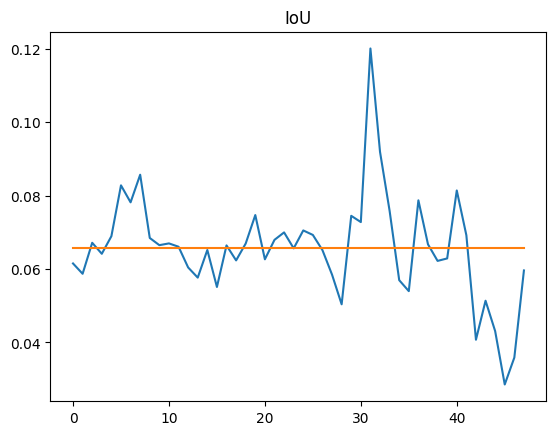

In [48]:
plt.plot(iou_list)
plt.plot(np.ones(len(iou_list))*np.mean(iou_list))
plt.title("IoU")
plt.show()